In [1]:
%reload_ext nb_black

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn import linear_model

from sqlalchemy import create_engine
import statsmodels.api as sm

%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

import warnings
warnings.filterwarnings(action="ignore")

import config

In [3]:
postgres_user = config.user
postgres_pw = config.password
postgres_host = config.host
postgres_port = config.port
postgres_db = "weatherinszeged"

engine = create_engine(
    "postgresql://{}:{}@{}:{}/{}".format(
        postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db
    )
)

df = pd.read_sql_query("select * from weatherinszeged", con=engine)

# No need for an open connection,
# because you're only doing a single query
engine.dispose()

In [4]:
df.head(3)

,date,summary,preciptype,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,loudcover,pressure,dailysummary
0,2006-03-31 22:00:00+00:00,Partly Cloudy,rain,9.472,7.389,0.890,14.120,251.000,15.826,0.000,1015.130,Partly cloudy throughout the day.
1,2006-03-31 23:00:00+00:00,Partly Cloudy,rain,9.356,7.228,0.860,14.265,259.000,15.826,0.000,1015.630,Partly cloudy throughout the day.
2,2006-04-01 00:00:00+00:00,Mostly Cloudy,rain,9.378,9.378,0.890,3.928,204.000,14.957,0.000,1015.940,Partly cloudy throughout the day.


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   date                 96453 non-null  datetime64[ns, UTC]
 1   summary              96453 non-null  object             
 2   preciptype           96453 non-null  object             
 3   temperature          96453 non-null  float64            
 4   apparenttemperature  96453 non-null  float64            
 5   humidity             96453 non-null  float64            
 6   windspeed            96453 non-null  float64            
 7   windbearing          96453 non-null  float64            
 8   visibility           96453 non-null  float64            
 9   loudcover            96453 non-null  float64            
 10  pressure             96453 non-null  float64            
 11  dailysummary         96453 non-null  object             
dtypes: datetime64[ns, 

In [8]:
x_cols = ['humidity', 'windspeed', 'windbearing', 'pressure']
y_cols = ['temperature']
X = df.loc[:,x_cols]
y = df.loc[:,y_cols]

In [19]:
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            temperature   R-squared:                       0.421
Model:                            OLS   Adj. R-squared:                  0.421
Method:                 Least Squares   F-statistic:                 1.750e+04
Date:                Wed, 16 Dec 2020   Prob (F-statistic):               0.00
Time:                        12:18:07   Log-Likelihood:            -3.2821e+05
No. Observations:               96453   AIC:                         6.564e+05
Df Residuals:                   96448   BIC:                         6.565e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          37.9264      0.233    162.709      0.000      37.470      38.383
humidity      -32.4962      0.123   -264.288      0.000     -32.737     -32.255
windspeed      -0.2014      0.003    -57.557      0.000      -0.208      -0.195
windbearing     0.0040      0.000     18.463      0.000       0.004       0.004
pressure       -0.0007      0.000     -3.452      0.001      -0.001      -0.000
==============================================================================
Omnibus:                     3375.432   Durbin-Watson:                   0.059
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3793.297
Skew:                          -0.455   Prob(JB):                         0.00
Kurtosis:                       3.339   Cond. No.                     1.06e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.06e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [35]:
predictions = model.predict()
errors = y.temperature-predictions
print('Mean of the errors in the model is : {}'.format(np.mean(errors)))

Mean of the errors in the model is : 1.495258729943169e-11


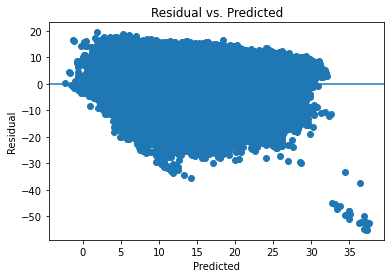

In [36]:
plt.scatter(predictions, errors)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

In [37]:
from scipy.stats import bartlett
from scipy.stats import levene

bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

Bartlett test statistic value is 2464.84 and p value is 0
Levene test statistic value is 2321.24 and p value is 0


Error is not distributed evenly throughout the predicted range of values. there is a cluster of negative errors in the '35' range of predicted values that may be of interest.

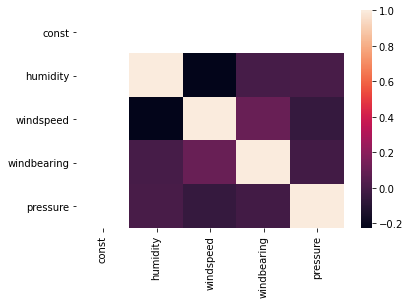

In [39]:
sns.heatmap(X.corr())
plt.show()

Nothing here is highly correlated. So, Low multicollinearity assumption is met.

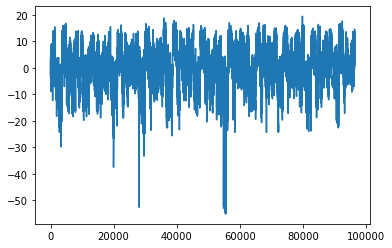

In [40]:
plt.plot(errors)
plt.show()

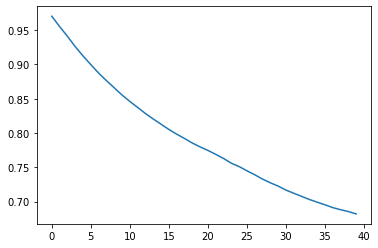

In [41]:
from statsmodels.tsa.stattools import acf

acf_data = acf(errors)

plt.plot(acf_data[1:])
plt.show()

Autocorrelation between the errors of the model is high. between (.7-.95+)

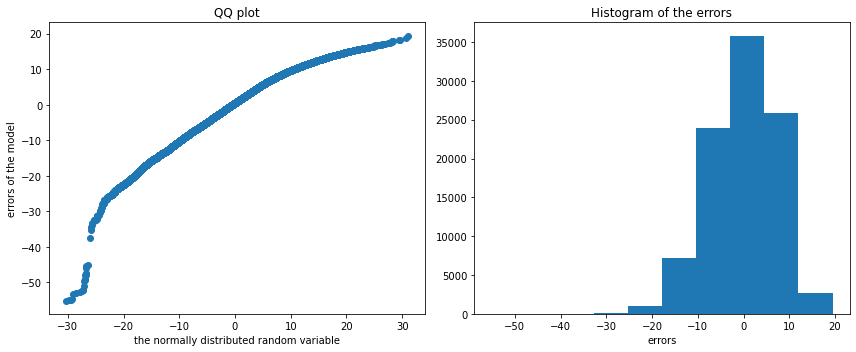

In [42]:
rand_nums = np.random.normal(np.mean(errors), np.std(errors), len(errors))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(np.sort(rand_nums), np.sort(errors)) # Sort the arrays
plt.xlabel("the normally distributed random variable")
plt.ylabel("errors of the model")
plt.title("QQ plot")

plt.subplot(1,2,2)
plt.hist(errors)
plt.xlabel("errors")
plt.title("Histogram of the errors")

plt.tight_layout()
plt.show()

In [43]:
from scipy.stats import jarque_bera
from scipy.stats import normaltest

In [44]:
jb_stats = jarque_bera(errors)
norm_stats = normaltest(errors)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 3793.296735252544 and p value is 0.0
Normality test statistics is 3375.432307699705 and p value is 0.0


 As suspected, the errors are not tested to be normal. Both of the p-values are < 0.05.